In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns  #python data visualization library based on matplotlib
%matplotlib inline

In [2]:
np.random.seed(2)

In [4]:
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [5]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [6]:
sns.set(style='white', context='notebook', palette='deep')

# Data Preparation

## Load data

In [10]:
# load the data
train = pd.read_csv("C:/Users/pjiang/Desktop/Jupyter/Practice/Data/train.csv")

test  = pd.read_csv("C:/Users/pjiang/Desktop/Jupyter/Practice/Data/test.csv")

In [17]:
Y_train = train['label'];

# Drop 'label' colum
X_train = train.drop(labels=['label'], axis = 1)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

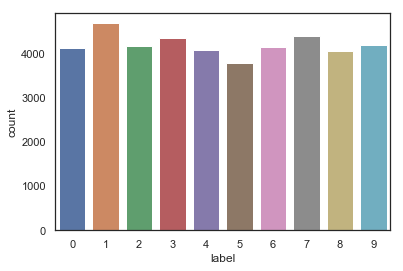

In [18]:
# free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

## 2.2 Check for null and missing values

In [19]:
# check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [20]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

check for corrupted images(missing values inside)
There is no missing values in the train and test dataset. Se we can safetly to go ahead.

## 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences<br>
Moreover the CNN converg faster on [0..1] data than on [0..255]

In [21]:
# Normalize the data
X_train = X_train/255.0
test = test /255.0

## 2.3 Reshape

In [22]:
# Reshape image in 3 dimensions(height = 28 px, width = 28px, canal =1)
X_train = X_train.values.reshape(-1, 28,28,1)
test = test.values.reshape(-1, 28,28,1)

Train and test images(28px, 28px) has been stock into pandas. Dataframe as 1D vectors of 784 values. we reshape all data to 28x28x1 3D matrices.<br>

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only  one channel. For RGB images, there is 3 channels, we would have reshaped 784px vector to 28x28x3 3D matrices.

## 2.4 Label encoding

In [23]:
# Encode labels to one hot vectors(ex: 2 ->[0,0,1,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these labels to one hot vector

## 2.6 Split training and validation set

In [24]:
#Set the random seed
random_seed =2 

In [26]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed)

I choosed to split the train set in two parts: a small fraction(10%) became the validation set which the model is evaluated and the rest(90%) is used to train the model<br>

Since we have 42 000 training images of balanced labels, a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.<br>

To avoid that, we could use stratify = True option in train_test_split function(only for >= 0.17 sklearn versions).<br>

We can get a better sense for one of these examples by visualising the image and looking at the label.

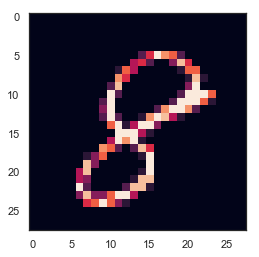

In [27]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# 3 CNN

## 3.1 Define the model

The first is convolutional(Conv2D) layer. It is like a set of learnable filter. I choosed to set 32 filters for the two firsts Conv2D layers and 64 filters for the two last one. Each filter transform a part of the image(define by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.<br>

The CNN can isolate features that are useful everywhere from these transformed images(feature maps).<br>

The second important layer in CNN is the pooling(MaxPool2D) layer. This layer simply acts as a downsampleing filter. It looks at the 2 neighboring piexl and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. we have to choose the pooling size(i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.<br>

Combining convolutional and pooling layers, CNN are able to combime local features and learn more global features of the image.<br>

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored(setting their weights to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generaliztion and reduces the overfitting.

'relu' is the rectifier(activation function max(0,x). The rectifier activation function is used to add non linearity to the network.<br>

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combimes all the found local features of the previous convolutional layers.<br>

In the end i used the features in two fully-connected(Dense) layers which is just artifical an neural networks(ANN) classifer. In the last layer(Dense(10,activation='softmax'))the net output distribution of probability of each class.

In [30]:
# Set teh CNN model
# CNN architechture is In-> [[Conv2D->relu] *2 -> MaxPool2D -> Dropput]*2 -> Flatten-> Dense->Dropout -> Out

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                 activation='relu', input_shape=(28,28,1)))

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = 'Same',
                activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))  ##should be dropout(0.5)
model.add(Dense(10, activation='softmax'))

## 3.2 Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimization algorithm.<br>

We define the loss function to measure how poorly our model performs on images with know labels. It is the error rate between the observed labels and predicted ones. We use a specific form for categorical classification(>2 classes) called the "categorical_crossentropy".<br>

The most important function is the optimizer. This function will iteratively improve parameters(filter kernel values, weights and bias of neurons..) in order to minimise the loss.<br>

I choose RMSprop(with default values). It is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, montonically decreasing learning rate. We could also have used Stochastic Gradient Descent('sgd') optimizer, but it is slower than RMSprop.<br>

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model(only for evaluation).

In [31]:
# Define the optimizer

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon = 1e-08, decay =0.0 )

In [32]:
# Compile the model
model.compile(optimizer = optimizer, loss= "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closet to the global minimum of the loss function, i used an annealing method of the learning rate(LR)<br>

The LR is the step by which the optimizer walks through the 'loos landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. Howerver the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.<br>

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.<br>

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps(epochs) depending if it is necessary(when accuarcy is not imporved).<br>

With the ReducelROnPleateau function from Keras.callbacks. i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [33]:
learning_rate_reduction = ReduceLROnPlateau(monitor ='val_acc',
                                           patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [34]:
epochs = 1 # Turn epochs to 30 get 0.9967 accuracy
batch_size = 86


## 3.3 Data augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make our existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.<br>

For example, the number is not centered The scale is not the same(some one who write with big/small number) The image is rotated...<br>

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations popole use are grayscales, horizontal flips, vertical flip, random crops, color jitters, translations, rotations, and much more.<br>

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.<br>

The improvement is important:
* Without data augmentation i obtained an accuracy of 98.114%
* With data augmentation i achieved 99.67% of accuracy

In [35]:
# Without data augmentation 
#history = model.fit(X_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), verbose=2)

In [37]:
# With data augmentation

datagen = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center = False, # set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset
        samplewise_std_normalization = False, # divided each input by its std
        zca_whitening = False, # apply ZCA whitening
        rotation_range = 10, # randomly rotate image in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Ramdomly zoom image
        width_shift_range = 0.1, # Randomly shift image horizontally(fraction of total width)
        height_shift_range = 0.1, # randomly shift image vertically(fraction of total height)
        horizontal_flip = False, # randomly flip images
        vertical_flip = False # randomly flip images
)

In [38]:
datagen.fit(X_train)

For the data augmentation, i choosed to:
* randomly rotate some training images by 10 degrees
* randomly Zoom by 10% some training images
* randomly shift images horizontally by 10% of the width
* randomly shift images vertically by 10% of the height

Did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.<br>

Once our model is ready, we fit teh training dataset.

In [39]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                             epochs = epochs, validation_data=(X_val,Y_val),
                             verbose = 2, steps_per_epoch = X_train.shape[0]//batch_size,
                             callbacks = [learning_rate_reduction])

Epoch 1/1
 - 1299s - loss: 1.0618 - acc: 0.7366 - val_loss: 0.5098 - val_acc: 0.8557


# 4. Evaluate the model

## 4.1 Training and validation curves

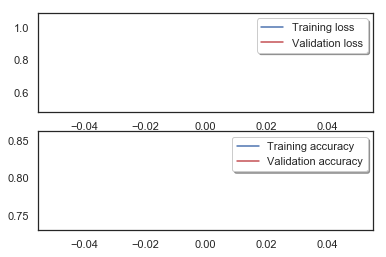

In [40]:
# Plot the loss and accuracy curves for training and validation

fig, ax = plt.subplots(2,1)

ax[0].plot(history.history['loss'], color='b', label = 'Training loss')
ax[0].plot(history.history['val_loss'], color = 'r', label='Validation loss', axes = ax[0])
legend = ax[0].legend(loc='best', shadow =True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color = 'r', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow = True)

## 4.2 Confusion matrix

Confusion matrix can be very helpful to see your model drawbacks

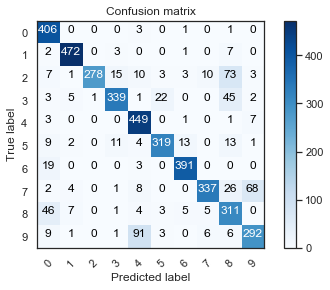

In [42]:
# Look at confusion matrix

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize = True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment = "center",
                color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)

#Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1)

#compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

#plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set(4200 images).<br>

However, it seems that our CNN has some litter troubles with 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curve as smooth.<br>


Let's investigate for errors.
I want to see the most important errors. For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.